# Understanding AIPW

*An introduction to doubly-robust estimation of conditional average treatment effects (CATE)*

When estimating causal effects, the gold standard is **randomized controlled trials or AB tests**. By randomly exposing units to a treatment we make sure that individuals in both groups are comparable, on average, and any difference we observe can be attributed to the treatment effect alone.

However, often the treatment and control groups are **not perfectly comparable**. This could be due to the fact that randomization was not perfect or available. Not always we can randomize a treatment, for ethical or practical reasons. And even when we can, sometimes we do not have enough individuals or units so that differences between groups are seizable. This happens often, for example, when randomization is not done at the individual level, but at a higher level of aggregation, for example zipcodes, counties or even states.

In a [previous post](https://towardsdatascience.com/99bf5cffa0d9), I have introduced and compared a series of methods that compute **conditional average treatment effects (CATE)** from observational or experimental data. Some of these methods require the researcher to specify and estimate the distribution of the outcome of interest, given the treatment and the observable characteristics (e.g. [meta learners](https://towardsdatascience.com/8a9c1e340832)). Other methods require the researcher to specify and estimate the probability of being treated, given the observable characteristics (e.g. [IPW](https://towardsdatascience.com/99bf5cffa0d9)). 

In this post, we are going to see a procedure that **combines** both methods and is **robust** to misspecification of either method's model: the Augmented Inverse Probability Weighted estimator (AIPW). 

<img src="fig/fusion.gif" width="400px"/>

**TLDR;** AIPW greatly improves both IPW and meta-learners, and you should always use it!

## Example

Assume we had blog on statistics and causal inference 😇. To improve user experience, we are considering **releasing a dark mode**, and we would like to understand whether this new feature increases the time users spend on our blog. 

This example is borrowed from my last post on the estimation of conditional average treatment effects (CATE). You can find the [original post here](https://towardsdatascience.com/99bf5cffa0d9). If you remember the setting, you can skip this introduction.

<img src="fig/modes.png" width="600px"/>

We are not a sophisticated company, therefore we do not run an AB test but we simply release the dark mode and we observe whether users select it or not and the time they spend on the blog. We know that there might be **selection**:  users that prefer the dark mode could have different reading preferences and this might complicate our causal analysis.

We can represent the data generating process with the following [**Directed Acyclic Graph (DAG)**](https://towardsdatascience.com/b63dc69e3d8c).

```mermaid
flowchart TB
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((gender))
X2((age))
X3((hours))
D((dark mode))
Y((read time))

D --> Y
X1 --> Y
X1 --> D
X2 --> D
X3 --> Y

class D,Y included;
class X1,X2,X3 excluded;
```

We generate the simulated data using the data generating process `dgp_darkmode()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
from src.utils import *
from src.dgp import dgp_darkmode

In [6]:
dgp = dgp_darkmode()
df = dgp.generate_data()
df.head()

,read_time,dark_mode,male,age,hours
0,14.4,False,0,43.0,65.6
1,15.4,False,1,55.0,125.4
2,20.9,True,0,23.0,642.6
3,20.0,False,0,41.0,129.1
4,21.5,True,0,29.0,190.2


We have informations on 300 users for whom we observe whether they select the `dark_mode` (the treatment), their weekly `read_time` (the outcome of interest) and some characteristics like `gender`, `age` and total `hours` previously spend on the blog.

We would like to estimate the effect of the new `dark_mode` on users' `read_time`. As a first approach, we might naively compute the effect as a difference in means, assuming that the treatment and control sample are comparable. We can estimate the difference in means by regressing `read_time` on `dark_mode`.

In [7]:
smf.ols("read_time ~ dark_mode", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,19.1748,0.402,47.661,0.000,18.383,19.967
dark_mode[T.True],-0.4446,0.571,-0.779,0.437,-1.568,0.679


Individuals that select the `dark_mode` spend on average 0.44 hours less on the blog, per week. Should we conclude that `dark_mode` is a **bad idea**? Is this a causal effect?

The problem is that we did **not** run an [**AB test**](https://de.wikipedia.org/wiki/A/B-Test) or randomized control trial, therefore users that selected the `dark_mode` might not be directly **comparable** with users that didn't. Can we verify this concern? Partially. We can only check characteristics that we observe, `gender`, `age` and total `hours` in our setting. We cannot check if users differ along other dimensions that we don't observe.

Let's use the `create_table_one` function from Uber's [`causalml`](https://causalml.readthedocs.io/) package to produce a **covariate balance table**, containing the average value of our observable characteristics, across treatment and control groups. As the name suggests, this should always be the first table you present in causal inference analysis.

We did not randomize the `dark_mode` so that users that selected it might not be directly **comparable** with users that didn't. Can we verify this concern? Partially. We can only check characteristics that we observe, `gender`, `age` and total `hours` in our setting. We cannot check if users differ along other dimensions that we don't observe.

Let's use the `create_table_one` function from Uber's [`causalml`](https://causalml.readthedocs.io/) package to produce a **covariate balance table**, containing the average value of our observable characteristics, across treatment and control groups. As the name suggests, this should always be the first table you present in causal inference analysis.

In [8]:
from causalml.match import create_table_one

X = ['male', 'age', 'hours']
table1 = create_table_one(df, 'dark_mode', X)
table1

,Control,Treatment,SMD
Variable,,,
n,151,149,
age,46.01 (9.79),39.09 (11.53),-0.6469
hours,337.78 (464.00),328.57 (442.12),-0.0203
male,0.34 (0.47),0.66 (0.48),0.6732


There seems to be **some difference** between treatment (`dark_mode`) and control group. In particular, users that select the `dark_mode` are older, have spent less hours on the blog and they are more likely to be males.

What can we do? If we assume that all differences between treatment and control group are **observable**, we can solve the problem by performing **conditional analysis**.

## Conditional Analysis

We assume that for a set of subjects $i = 1, ..., n$ we observed a set of variables $(D_i, Y_i, X_i)$ that includes

- a treatment assignment $D_i \in \lbrace 0, 1 \rbrace$ (`dark_mode`)
- a response $Y_i \in \mathbb R$ (`read_time`)
- a feature vector $X_i \in \mathbb R^n$ (`gender`, `age` and `hours`)

We are interested in **estimating the conditional average treatment effect (CATE)**.

$$
\tau(x) = \mathbb E \Big[ Y_i^{(1)} - Y_i^{(0)} \ \Big| \ X_i = x \Big]
$$

Where $Y_i^{(d)}$ indicates the potential outcome of individual $i$ under treatment status $d$. We also make the following assumptions.

**Assumption 1 : unconfoundedness** (or ignorability, or selection on observables)

$$
\big \lbrace Y_i^{(1)} , Y_i^{(0)} \big \rbrace \ \perp \ D_i \ | \ X_i
$$

i.e. conditional on observable characteristics $X$, the treatment assignment $D$ is as good as random. What we are effectively assuming is that there is no other characteristics that we do not observe that could impact both whether a user selects the `dark_mode` and their `read_time`. This is a **strong assumption** that is more likely to be satisfied the more individual characteristics we observe.

**Assumption 2: overlap** (or common support)

$$
\exists \eta > 0 \ : \ \eta \leq \mathbb E \left[ D_i = 1 \ \big | \ X_i = x \right] \leq 1-\eta
$$

i.e. no observation is deterministically assigned to the treatment or control group. This is a more technical assumption that basically means that for any level of `gender`, `age` or `hours`, there could exist an individual that select the `dark_mode` and one that doesn't. Differently from the unconfoundedness assumption, the overal assumption is **testable**.

**Assumption 3: stable unit treatment value (SUTVA)**

$$
Y^{(d)} \perp D
$$

i.e. the potential outcome does not depend on the treatment status. In our case, we are ruling out the fact that another user selecting `dark_mode` might affect my effect of `dark_mode` on `read_time`. The most common setting where SUTVA is violated is in presence of **network effects**: if a friend of mine uses a social network increases my utility from using it.

### IPW and Meta-Learners

Two alternative ways to perform conditional analysis are 

1. [**IPW**](https://towardsdatascience.com/99bf5cffa0d9): balance observations by their conditional treatment assignment probability and then estimate the treatment effect as a weighted difference in means
2. [**Meta Learners**](https://towardsdatascience.com/8a9c1e340832): predict the potential outcomes from observable characteristics and estimate treatment effects as the difference between observed and counterfactual outcomes

These two alternative procedures exploit the fact that we observe individual characteristics $X$ in different ways:

1. IPW exploits $X$ to predict the treatment assignment $D$ and estimate the **propensity scores** $e(X) = \mathbb{E} [D | X]$
2. Meta Learners exploit $X$ to predict the counterfactual outcomes $Y^{(d)}$ and estimate the **response function** $\mu(X)^{(d)} = \mathbb{E} [Y | D, X]$

Can we **combine** the two procedures and get the best of both worlds? 

Yes, with the **AIPW or double-robust estimator**.

## The AIPW Estimator

The **Augmented Inverse Propensity Weighted** estimator is given by

$$
\hat \tau_{AIPW} = \frac{1}{n} \sum_{i=1}^{n} \left( \hat \mu^{(1)}(X_i) - \hat \mu^{(0)}(X_i) + \frac{D_i }{\hat e(X_i)} \left( Y_i - \hat \mu^{(1)}(X_i) \right) - \frac{(1-D_i) }{1-\hat e(X_i)} \left( Y_i - \hat \mu^{(0)}(X_i) \right) \right)
$$

where $\mu^{(d)}(x)$ is the **response function**, i.e. the expected value of the outcome, conditional on observable characteristics $x$ and treatment status $d$, and $e(X)$ is the **propensity score**.

$$
\mu^{(d)}(x) = \mathbb E \left[ Y_i \ \big | \ X_i = x, D_i = d \right] \qquad ; \qquad e(x) = \mathbb E \left[ D_i = 1 \ \big | \ X_i = x \right]
$$

The formula of the AIPW estimator seems very cryptic at first, so let's dig deeper and try to understand it.

### Decomposition

The best way to understand the AIPW formula is to **decompose** it into two parts.

The **first way** is to decompose the AIPW estimator into a [**S-learner estimator**](https://towardsdatascience.com/8a9c1e340832) and an adjustment factor.

$$
\hat \tau_{AIPW} = \hat \tau_{S-learn} + \widehat{\text{adj}}_{S-learn}
$$

where

$$
\begin{aligned}
\hat \tau_{S-learn} =& \frac{1}{n} \sum_{i=1}^{n} \left( \hat \mu^{(1)}(X_i) - \hat \mu^{(0)}(X_i) \right) \newline
\widehat {adj} _ {S-learn} =& \frac{1}{n} \sum_{i=1}^{n} \left(\frac{D_i }{\hat e(X_i)} \left( Y_i - \hat \mu^{(1)}(X_i) \right) - \frac{(1-D_i) }{1-\hat e(X_i)} \left( Y_i - \hat \mu^{(0)}(X_i) \right) \right)
\end{aligned}
$$

The adjustment is essentially an IPW estimator performed on the **residuals** of the S-learner.

The **second way** to decompose the AIPW estimator into the **IPW estimator** and an adjustment factor.

$$
\hat \tau_{AIPW} = \hat \tau_{IPW} + \widehat{\text{adj}}_{IPW}
$$

where

$$
\begin{aligned}
\hat \tau_{IPW} &= \frac{1}{n} \sum _ {i=1}^{n} \left( \frac{D_i Y_i}{\hat e(X_i)} - \frac{(1-D_i) Y_i}{1-\hat e(X_i)} \right) \newline
\widehat {adj} _ {IPW} &= \frac{1}{n} \sum_{i=1}^{n} \left( \frac{\hat e(X_i) - D_i}{\hat e(X_i)} \hat \mu^{(1)}(X_i) - \frac{(1-\hat e(X_i)) - (1-D_i)}{1-\hat e(X_i)} \hat \mu^{(0)}(X_i) \right)
\end{aligned}
$$

The adjustment is essentially an S-learner estimator weighted by the residual treatment probabilities.

### Double Robustness

Why is the AIPW estimator so **compelling**? The reason is that it just needs one of the two predictions, $\hat \mu$ or $\hat e$, to be right in order to be **unbiased** (i.e. correct on average). Let's check it.

If $\hat \mu$ is correctly specified, i.e. $\mathbb E \left[ \hat \mu^{(d)}(x) \right] = \mathbb E \left[ Y_i \ \big | \ X_i = x, D_i = d \right]$, then $\hat \tau_{AIPW}$ is unbiased, **even if** $\hat e$ is misspecified.

$$
\begin{aligned}
\hat \tau_{AIPW} &\overset{p}{\to} \mathbb E \Big[ \hat \tau_{S-learn} + \widehat{\text{adj}}_{S-learn} \Big] = \newline
&= \mathbb E \left[ \hat \mu^{(1)}(X_i) - \hat \mu^{(0)}(X_i) + \frac{D_i \left( Y_i - \hat \mu^{(1)}(X_i) \right)}{\hat e(X_i)} - \frac{(1-D_i) \left( Y_i - \hat \mu^{(0)}(X_i) \right)}{1-\hat e(X_i)} \right] = \newline
&= \mathbb E \left[ \hat \mu^{(1)}(X_i) - \hat \mu^{(0)}(X_i) \right] = \newline
&= \mathbb E \left[ Y^{(1)} - Y^{(0)} \right] = \newline
&= \tau
\end{aligned}
$$

The **intuition** is that, if $\hat \mu$ is correctly specified, $\hat \tau_{S-learn}$ is **unbiased** and the adjustment factor **vanishes**, since the residuals $\left( Y_i - \hat \mu^{(t)}(X_i) \right)$ converge to zero.

On the other hand, if $\hat e$ is correctly specified, i.e. $\mathbb E \left[\hat e(x) \right] = \mathbb E \left[ D_i = 1 \ \big | \ X_i = x \right]$, then $\hat \tau_{AIPW}$ is unbiased, **even if** $\hat \mu$ is misspecified.

$$
\begin{aligned}
\hat \tau_{AIPW} & \overset{p}{\to} \mathbb E \Big[ \hat \tau_{IPW} + \widehat{\text{adj}}_{IPW} \Big] = \newline
&= \mathbb E \left[ \frac{D_i Y_i}{\hat e(X_i)} - \frac{(1-D_i) Y_i }{1-\hat e(X_i)} + \frac{\hat e(X_i) - D_i}{\hat e(X_i)} \hat \mu^{(1)}(X_i) - \frac{(1-\hat e(X_i)) - (1-D_i)}{1-\hat e(X_i)} \hat \mu^{(0)}(X_i) \right] = \newline
&= \mathbb E \left[ \frac{D_i Y_i}{\hat e(X_i)} - \frac{(1-D_i) Y_i }{1-\hat e(X_i)}\right] = \newline
&= \mathbb E \left[ Y^{(1)} - Y^{(0)} \right] = \newline
&= \tau
\end{aligned}
$$ 

The **intuition** is that, if $\hat e$ is correctly specified, $\hat \tau_{IPW}$ is **unbiased** and the adjustment factor **vanishes**, since the residuals $\left( D_i - \hat e (X_i) \right)$ converge to zero. 

### Best Practices

**1. Check Covariate Balance**

Both IPW and AIPW were built for settings in which the treatment $D$ is not unconditionally randomly assigned, but might depend on some observables $X$. This information can be checked in two ways:

1. Produce a balance table, summarizing the covariates across treatment arms. If unconditional randomization does not hold, we expect to see significant differences across some observables
2. Plot the estimated propensity scores. If unconditional randomization holds, we expect the propensity scores to be constant

**2. Check the Overlap Assumption**

Another assumption that we can check is the **overlap** assumption, i.e. $\exists \eta \ : \ \eta \leq \mathbb E \left[ D_i = 1 \ \big | \ X_i = x \right] \leq 1-\eta$. To check this assumption we can simply check the bounds of the predicted propensity scores. If the overlap assumption is violated, we end up dividing some term of the estimator by zero.

**3. Use Cross-Fitting**

Whenever we build a prediction, it is best practice to exclude observation $i$ when estimating $\hat \mu^{(d)} (X_i)$ or $\hat e (X_i)$. This procedure is generally known as [**cross-fitting**](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) in the machine learning literature. While there are many possible ways to perform cross-fitting, the simplest one is the following:

1. Split the sample in two at random
2. Use sample 1 to estimate $\hat \mu^{(d)} (X_i)$ and $\hat e (X_i)$
3. Use sample 2 to estimate $\hat{\tau}_{AIPW, 1}$
4. Repeat (2) and (3) swapping samples to estimate $\hat{\tau}_{AIPW, 2}$
5. Compute $\hat{\tau}_{AIPW}$ as the average of the two estimates

Steps (2) and (3) ensure that the estimator is **not overfitting**. Steps (4) and (5) ensure that the estimator is **efficient**, using all the data for all steps and not just half. [Kennedy (2022)](https://arxiv.org/abs/2004.14497) shows that this procedure produces much more precise estimates than existing methods and provide formal results on error bounds. In particular, their main result is the following:

> "*The bound on the DR-Learner error given in Theorem 2 shows that it can only deviate from the oracle error by at most a (smoothed) product of errors in the propensity score and regression estimators, thus allowing faster rates for estimating the CATE even when the nui- sance estimates converge at slower rates. Importantly the result is agnostic about the methods used, and requires no special tuning or undersmoothing.*"

## Back to the Data

Let's now build and explore the AIPW estimator in our dataset on blog reading time and dark mode. 

### Propensity Scores

First, let's estimate the **propensity scores** $e(X)$.

In [9]:
def estimate_e(df, X, D, model_e):
    e = model_e.fit(df[X], df[D]).predict_proba(df[X])[:,1]
    return e

We estimate them by [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) using the `LogisticRegression` methods from the `sklearn` package.

In [10]:
from sklearn.linear_model import LogisticRegression

df['e'] = estimate_e(df, X, "dark_mode", LogisticRegression())

Let's check if the **bounded support** assumption is satisfied, by plotting the estimated propensity scores, across treatment and control groups.

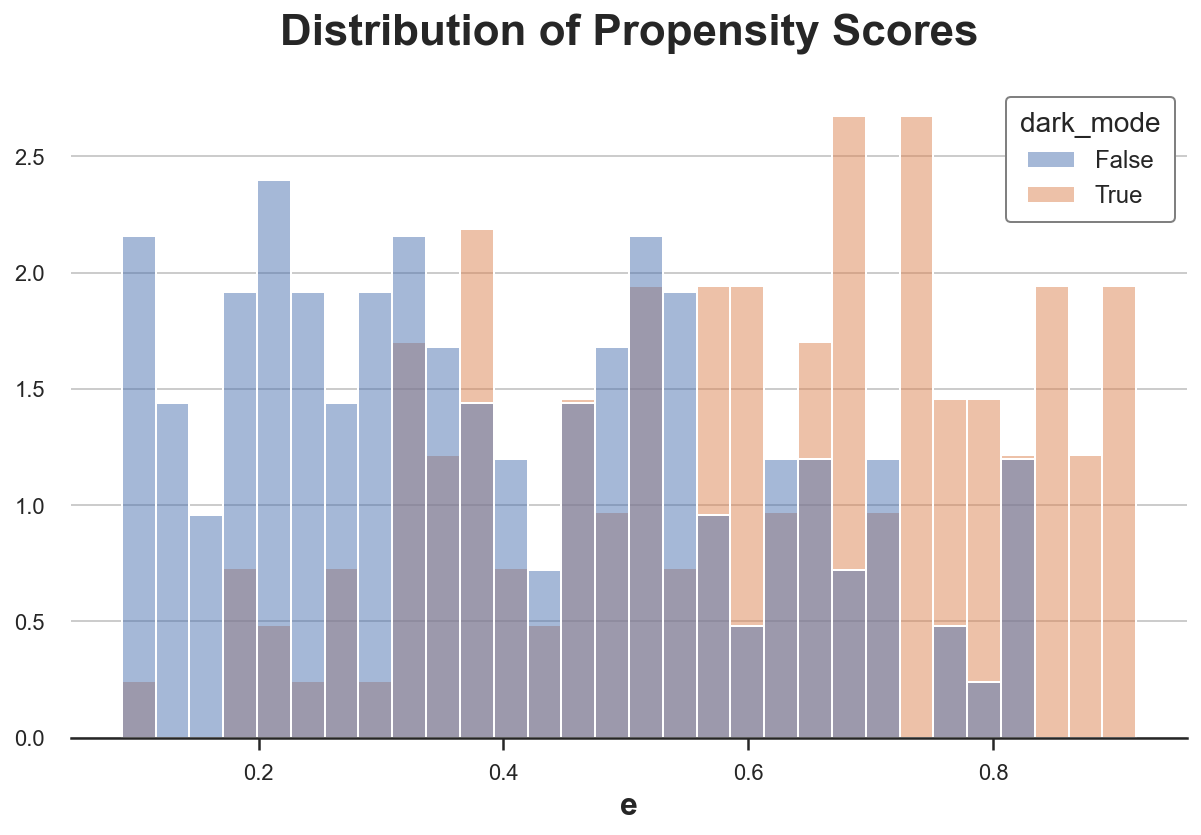

In [11]:
sns.histplot(data=df, x='e', hue='dark_mode', bins=30, stat='density', common_norm=False).\
    set(ylabel="", title="Distribution of Propensity Scores");

The distribution of propensity scores is different between two groups, but it's generally overlapping.

We can now use the propensity scores to build the IPW estimator.

In [15]:
w = 1 / (e * df["dark_mode"] + (1-e) * (1-df["dark_mode"]))
smf.wls("read_time ~ dark_mode", weights=w, data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.6099,0.412,45.159,0.000,17.799,19.421
dark_mode[T.True],1.0620,0.582,1.826,0.069,-0.083,2.207


Note that the computed standard errors are not exact, since we are ignoring the extra uncertainty that comes from the estimation of the propensity scores $e(X)$.

### Response Function

Let's now estimate the second building block of the AIPW estimator: the **response function** $\mu(X)$.

In [17]:
def estimate_mu(df, X, D, y, model_mu):
    mu = model_mu.fit(df[X + [D]], df[y])
    mu0 = mu.predict(df[X + [D]].assign(dark_mode=0))
    mu1 = mu.predict(df[X + [D]].assign(dark_mode=1))
    return mu0, mu1

Let's start by estimating $\mu(X)$ with linear regression.

In [16]:
from sklearn.linear_model import LinearRegression

mu0, mu1 = estimate_mu(df, X, "dark_mode", "read_time", LinearRegression())
print(np.mean(mu1-mu0))

1.3858099131476969


We have computed the meta learner estimate of the average treatment effect as the difference in means between the two estimated response functions, $\mu^{(1)}(X)$ and $\mu^{(0)}(X)$.

**Note** that we can use any estimator to get the response function, I used linear regression for simplicity.

### Estimating AIPW

We now have **all the building blocks** to compute the AIPW estimator!

In [23]:
aipw = mu1 - mu0 + df["dark_mode"] / e * (df["read_time"] - mu1) - (1-df["dark_mode"]) / (1-e) * (df["read_time"] - mu0)
print(np.mean(aipw))

1.3153774511905783


We can also compute it directly using the `LinearDRLearner` function from Microsoft's [`EconML`](https://econml.azurewebsites.net/index.html) library. 

In [24]:
from econml.drlearner import LinearDRLearner

model = LinearDRLearner(model_propensity=LogisticRegression(), 
                        model_regression=LinearRegression(),
                        random_state=1)
model.fit(Y=df["read_time"], T=df["dark_mode"], X=df[X]);

The model directly gives us the average treatment effect.

In [25]:
model.ate_inference(X=df[X].values, T0=0, T1=1).summary().tables[0]

mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
1.417,0.541,2.621,0.009,0.358,2.477


The estimate is statistically different from zero and the confidence interval includes the true value of 2. 

**Note** that we got a different estimate because the `LinearDRLearner` function also performed **cross-fitting** in the background, which we did not before.

### Assessment

Let's now assess the main property of the AIPW estimator: its **double robustness**. To do so, we compare it with its two parents: the IPW estimator and the S-learner.

In [18]:
def compare_estimators(X_e, X_mu, D, y, seed):
    df = dgp_darkmode().generate_data(seed=seed)
    e = estimate_e(df, X_e, D, LogisticRegression())
    mu0, mu1 = estimate_mu(df, X_mu, D, y, LinearRegression())
    slearn = mu1 - mu0
    ipw = (df[D] / e - (1-df[D]) / (1-e)) * df[y]
    aipw = slearn + df[D] / e * (df[y] - mu1) - (1-df[D]) / (1-e) * (df[y] - mu0)
    return np.mean((slearn, ipw, aipw), axis=1)

We use the [`joblib`](https://joblib.readthedocs.io/en/latest/) library to run the simulations in parallel and speed up the process.

In [19]:
from joblib import Parallel, delayed

def simulate_estimators(X_e, X_mu, D, y):
    r = Parallel(n_jobs=8)(delayed(compare_estimators)(X_e, X_mu, D, y, i) for i in range(100))
    df_tau = pd.DataFrame(r, columns=['S-learn', 'IPW', 'AIPW'])
    plot = sns.boxplot(data=pd.melt(df_tau), x='variable', y='value', linewidth=2);
    plot.set(title="Distribution of $\hat τ$ and its components", xlabel='', ylabel='')
    plot.axhline(2, c='r', ls=':');

First, let's assume that we use **all variables** for both models, $\mu(X)$ and $e(X)$. In this case, both models are **well specified** and we expect all estimators to perform well.

We plot the distribution of the three estimators across 100 simulations. 

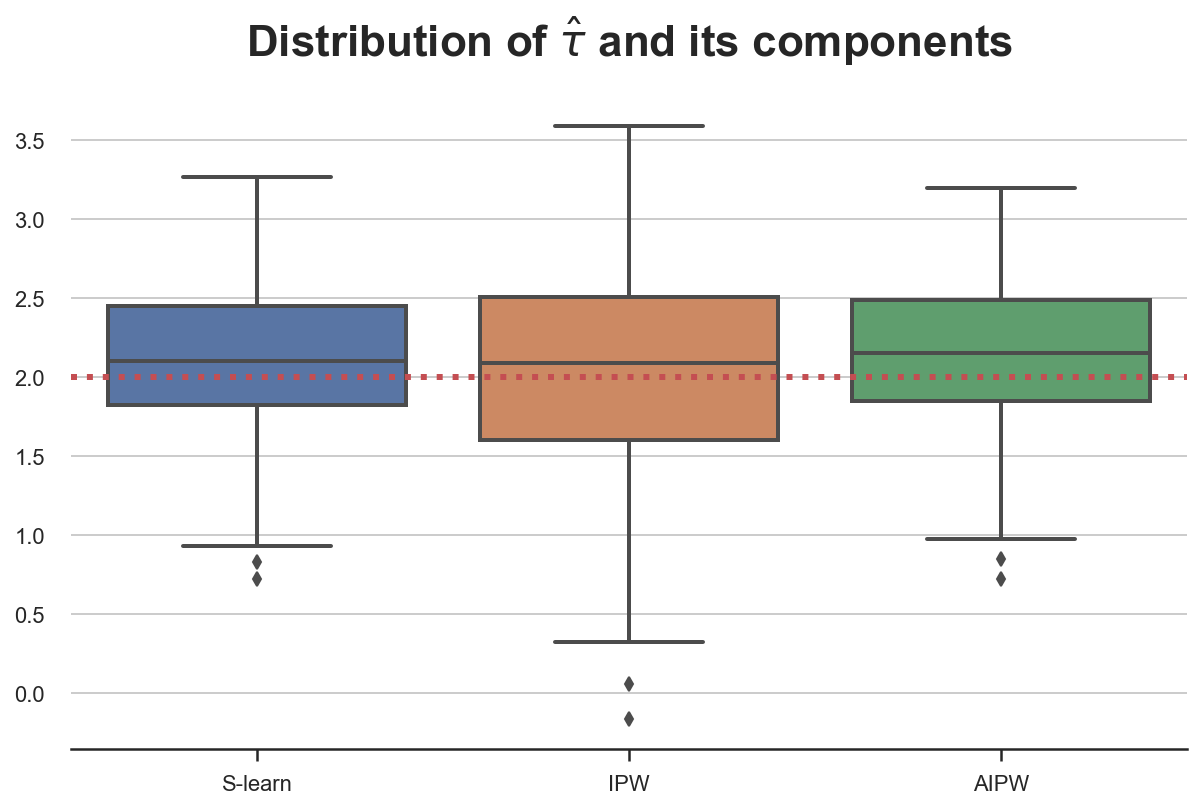

In [20]:
simulate_estimators(X_e=X, X_mu=X, D="dark_mode", y="read_time")

Indeed, all estimator are **unbiased** and deliver very similar estimates.

What happens if we **misspecify** one of the two models? Let's start by (correctly) assuming that `gender` and `age` influence the probability of selecting `dark_mode` and (wrongly) assuming that only previous `hours` influence the weekly `read_time`. In this case, the propensity score $e(X)$ is well specified, while the response function $\mu(X)$ is misspecified.

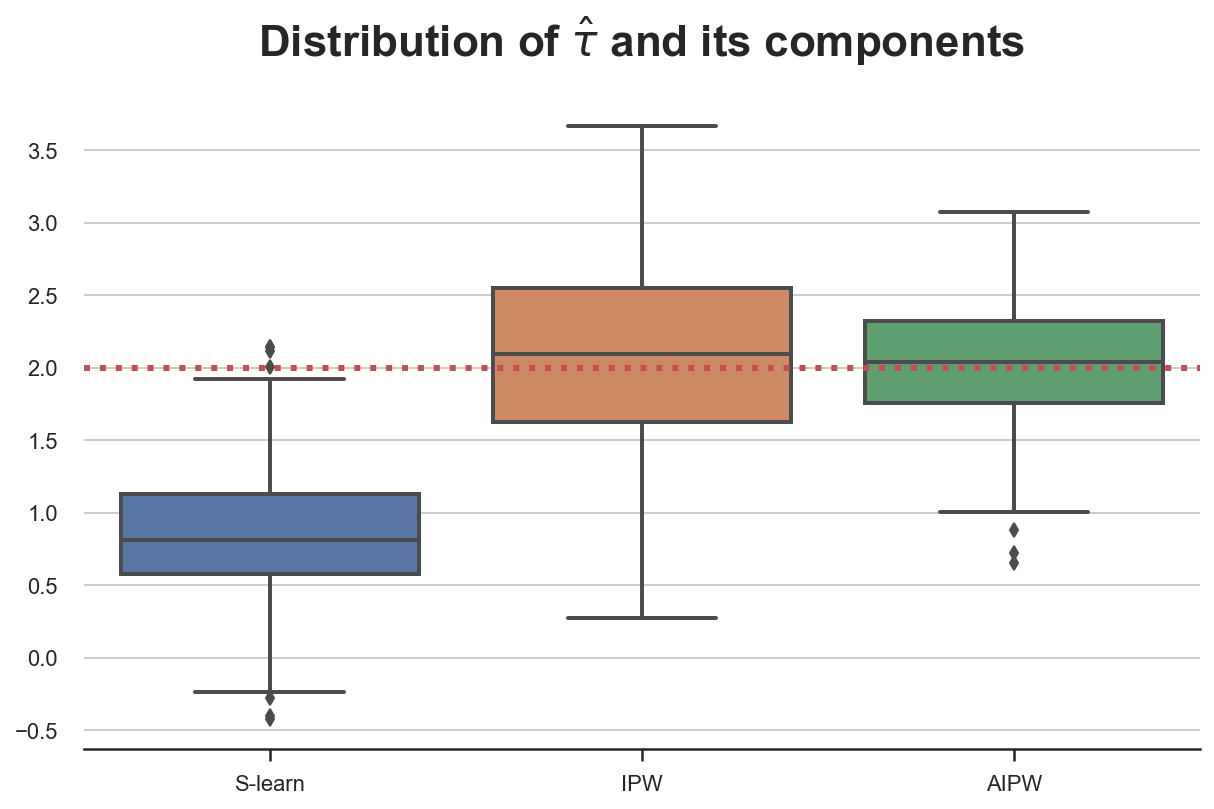

In [21]:
simulate_estimators(X_e=['male', 'age'], X_mu=['hours'], D="dark_mode", y="read_time")

As expected, the S-learner is biased since we have misspecified $\mu(X)$, while IPW isn't. AIPW picks the **best of both worlds** and is unbiased.

Let's now explore the alternative **misspecification**. We (wrongly) assume that only `age` influences the probability of selecting `dark_mode` and (correctly) assume that both `gender` and previous `hours` influence the weekly `read_time`. In this case, the propensity score $e(X)$ is misspecified, while the response function $\mu(X)$ is correctly specified.

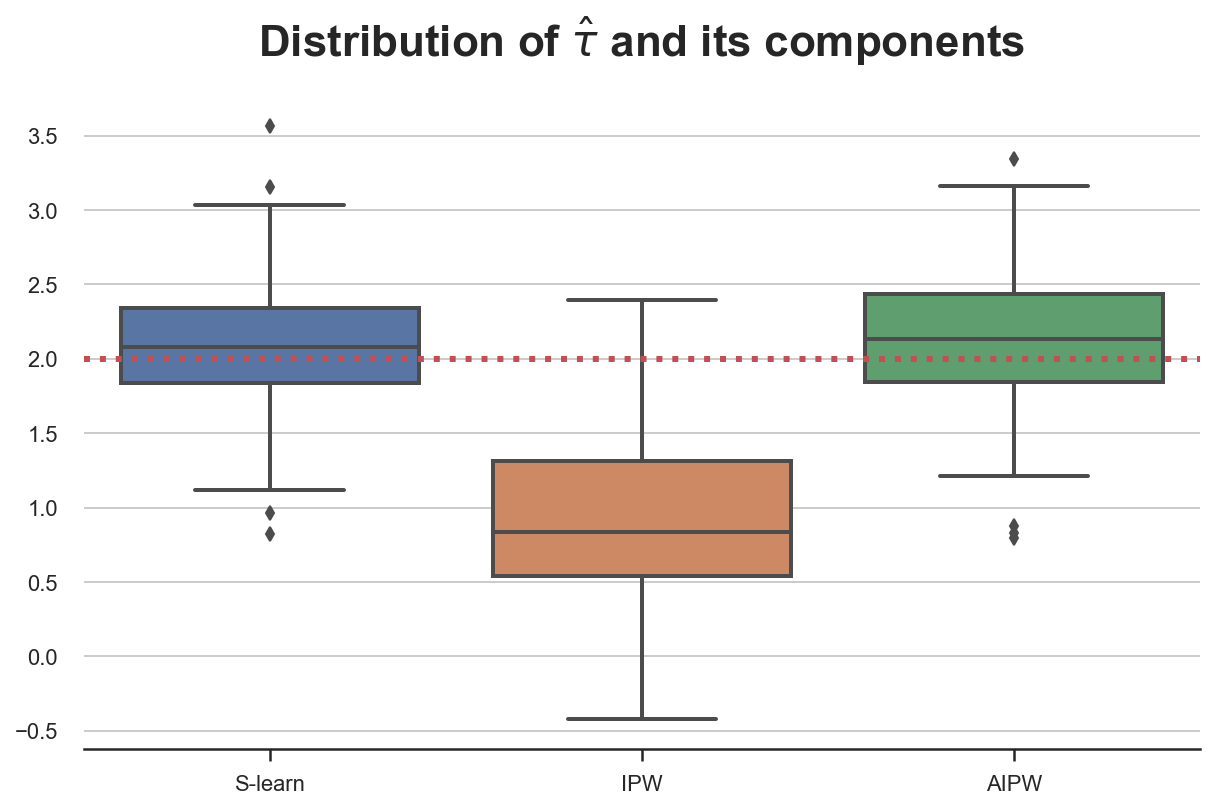

In [22]:
simulate_estimators(['age'], ['male', 'hours'], D="dark_mode", y="read_time")

In this case, the S-learner is unbiased, while IPW isn't, since we have misspecified $e(X)$. Again, AIPW picks the **best of both worlds** and is unbiased.

## Conclusion

In this article we have seen a method to estimate conditional average treatment effects (CATE), that is **robust to model misspecification**: the Augmented Inverse Propensity Weighted (AIPW) estimator. The AIPW estimator takes the best out of two existing estimators: the [IPW estimator]() and the [S-learner](). It requires the estimation of both the propensity score function $\mathbb{E} [ D | X ]$ and the response function $\mathbb{E} [ Y | D, X ]$ and it is **unbiased** even if one of the two functions is misspecified.

This estimator is now a standard and it is included all the most important causal inference packages such as Microsoft's [EconML](https://econml.azurewebsites.net/), Uber's [causalml](https://causalml.readthedocs.io/) and Stanford researchers' R package [grf](https://grf-labs.github.io/grf/).

### References

[1] J. Robins, A. Rotzniski, J. P. Zhao, [Estimation of regression coefficients when some regressors are not always observed](https://www.tandfonline.com/doi/abs/10.1080/01621459.1994.10476818) (1994), *Journal of the American Statistical Associations*.

[2] A. Glyn, K. Quinn, [An Introduction to the Augmented Inverse Propensity Weighted Estimator](https://www.cambridge.org/core/journals/political-analysis/article/abs/an-introduction-to-the-augmented-inverse-propensity-weighted-estimator/4B1B8301E46F4432C4DCC91FE20780DB) (2010), *Political Analysis*.

[3] E. Kennedy, [Towards optimal doubly robust estimation of heterogeneous causal effects](https://arxiv.org/abs/2004.14497) (2022), *working paper*.

### Related Articles

- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)
- [Matching, Weighting, or Regression?](https://towardsdatascience.com/99bf5cffa0d9)
- [Understanding Meta Learners](https://towardsdatascience.com/8a9c1e340832)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/aipw.ipynb